In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from IPython.display import display


In [ ]:
#reading df
path = r"C:\Users\Ahmed\Desktop\Project Mats\CLV-Prediction-Project\data\Metrics.csv"
df = pd.read_csv(path)

#data representation
df.describe()

In [ ]:
#adding quantityperorder column
df["QuantityPerOrder"] = df["TotalQuantity"] / df["Frequency"]
df["QuantityPerOrder"].describe()

In [ ]:
#Visualize distributions and boxplots for each column except CustomerID
for label in df.columns[1:]:
    plt.figure(figsize=(4,3))
    plt.hist(df[label])
    plt.xlabel(label)
    plt.show()

    plt.figure(figsize=(4,3))
    plt.boxplot(df[label])
    plt.show()




In [ ]:
#Drop rows where CLV is negative
#(Because negative values returns NaN when log transforming data so it will be useless either way)
#(The reason because of negative CLV is because some avgorder value in negative which is because high returns)
df = df[df['CLV'] >= 0]
#Apply log and square root transformations to selected columns
to_transform = ["TotalSales", "Frequency", "AverageOrderValue", "CLV","TotalQuantity","QuantityPerOrder"]
dflogged = df.copy()
for label in to_transform:
    if label == "CLV":
        dflogged[label] = np.log1p(dflogged[label])
    else:
        dflogged[label] = np.sqrt(dflogged[label])
#somehow this creates 2 NAN values in 2 columns which we can afford to lose so we will delete these rows
dflogged = dflogged.dropna().reset_index(drop=True)


In [ ]:
dflogged.describe()

In [ ]:
for label in dflogged.columns[1:]:
    #histograms
    plt.figure(figsize=(4,3))
    sns.histplot(dflogged[label],bins=6,kde=True)
    plt.xlabel(label)
    plt.show()
    #boxplots
    plt.figure(figsize=(4,3))
    sns.boxplot(dflogged[label])
    plt.xlabel(label)
    plt.show()

In [ ]:
#Calculate IQR-based bounds for outlier detection for selected columns
columns_to_check = ["TotalSales", "Frequency", "AverageOrderValue","TotalQuantity","QuantityPerOrder","CLV"]
bounds = {}

for col in columns_to_check:
    Q1 = dflogged[col].quantile(0.25)
    Q3 = dflogged[col].quantile(0.75)
    IQR = Q3 - Q1
    bounds[col] = (Q1 - 1.5 * IQR,Q3 + 1.5 * IQR)


In [ ]:
#Filter out outliers based on IQR bounds for selected columns
mask = pd.Series(True,index=dflogged.index)
for col in columns_to_check:
    low, high = bounds[col]
    mask &= (dflogged[col] >= low) & (dflogged[col] <= high)

dflogged = dflogged[mask].reset_index(drop=True)
dflogged.describe()

#NOTE for later 
#&= not = (line 5)

In [ ]:
for label in dflogged.columns[1:]:
    #histograms
    plt.figure(figsize=(4,3))
    sns.histplot(dflogged[label],bins=6,kde=True)
    plt.xlabel(label)
    plt.show()
    #boxplots
    plt.figure(figsize=(4,3))
    sns.boxplot(dflogged[label])
    plt.xlabel(label)
    plt.show()
   

In [ ]:
#Compute correlation matrix and plot heatmap for transformed features (excluding 'Segment')
DfForHeatMap = dflogged.corr(method="pearson")
sns.heatmap(DfForHeatMap, annot=True, fmt=".2f", linewidth=.5)
plt.show()

Regression

In [ ]:
#Split features and target variable for regression
X = dflogged.drop(columns=["CLV"])
Y = dflogged["CLV"]


In [ ]:
#Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)


In [ ]:
#defining regression model
rmodel = linear_model.LinearRegression()

In [ ]:
#building the training model
rmodel.fit(X_train, Y_train)

In [ ]:
#using trained model to pridict on X_test
Y_pred = rmodel.predict(X_test)

In [ ]:
#printing model perfomance
CoefficientValues = pd.DataFrame({"Feature": X.columns, "Coefficient": rmodel.coef_})
display(CoefficientValues)
print("intercept:",rmodel.intercept_)
print("mean sqr error:",mean_squared_error(Y_test,Y_pred))
print("r2score",r2_score(Y_test,Y_pred))
#checking for overfitting by calculating r2 for our training data
print("Train R2:", r2_score(Y_train, rmodel.predict(X_train)))



Clustering

In [ ]:
#Select features for clustering (excluding 'CLV' and any non-numeric columns)
FeaturesForClustering = dflogged[["CLV"]]

#Fit KMeans clustering model (let's use 3 clusters as an example)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(FeaturesForClustering)

#Add cluster labels to the dataframe
dflogged["Segment"] = clusters

#Map cluster labels to descriptive names
dflogged["Segment"] = dflogged["Segment"].map({0:"medium",1:"low",2:"high"})
#Show cluster counts
dflogged["Segment"].value_counts()
#Visualize the clusters by plotting CLV values colored by segment
sns.scatterplot(x=dflogged.index, y=dflogged["CLV"],hue=dflogged["Segment"])
plt.xlabel("Index")
plt.ylabel("CLV")
plt.title("CLV Clusters by Segment")
plt.show()

#NOTE
# random_state=42 outputed 3 cluster with three 3 random labels that's why we had to make them meaningful by labeling them into low medium and high
# if random_state=42 is changed or removed everytime it will output random labels



In [ ]:
#Calculate silhouette score for the current KMeans clustering on X(CLV)
score = silhouette_score(X, kmeans.fit_predict(X))
print(score)

In [ ]:

#Plot the distribution of customer segments as a pie chart
SegmentCounts = dflogged['Segment'].value_counts()
plt.pie(SegmentCounts, labels=SegmentCounts.index, autopct='%1.1f%%', startangle=90)
plt.title('Customer Segment Distribution')
plt.show()
SegmentCounts

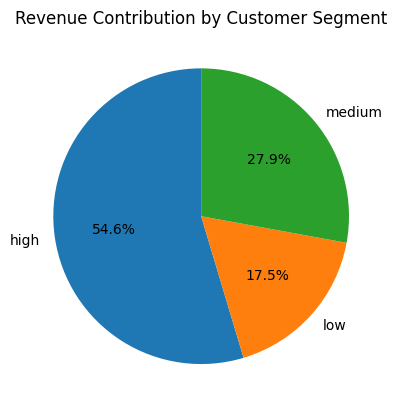

Segment
high      522794.76
low       167320.30
medium    266800.01
Name: TotalSales, dtype: float64

In [23]:
#Assign segment labels from dflogged to df
OriginalTotalSales = df["TotalSales"]
dflogged["TotalSales"] = OriginalTotalSales

#Group by Segment and sum TotalSales, sorting segments as high > medium > low
result = dflogged.groupby("Segment")["TotalSales"].sum()

#Plot revenue contribution by customer segment as a pie chart
plt.pie(result, labels=result.index, startangle=90, autopct='%.1f%%')
plt.title("Revenue Contribution by Customer Segment")
plt.show()
result




